# Look at the low variance features - are they useless?

As pointed out by Chris Deotte, the features for each value of wheezy-copper-turtle-magic have either a 'high' or 'low' variance. Chris suggested that the low variance features were not useful predictors of the target.

Another [kernel](https://www.kaggle.com/mhviraf/there-is-predictive-power-in-the-useless-columns) also questioned if they were useful. 

Chris also [demonstrated](https://www.kaggle.com/c/instant-gratification/discussion/93379) the curse of dimensionality, and how it can lead to seperability, even for random noise.

I wanted to do a quick check of if the low-variance features were indeed useless. I thought I might as well share the kernel. I just fitted a quick NuSVC using three different feature selection methods.


**Summary:** Assuming the features are independent, it does not appear the low-variance features contain any useful predictors of the target. This agrees with all previous work.

In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVC

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv']


In [2]:
def get_data(target_name='target'):
    """
    Gets the training data and extracts the target. 
    
    Returns:
        train (pd.DataFrame): training data.
        target (np.ndarray): target values, binary
    """
    train = pd.read_csv("../input/train.csv")
    test = pd.read_csv("../input/test.csv")
    try:
        target = train[target_name]
        train.drop(target_name, axis=1, inplace=True)
    except KeyError:
        # no column named target_name, find binary column
        for key in train.columns:
            x = train[key].values
            if np.array_equal(x, x.astype(bool)):
                target_name = key
        target = train[target_name]
        train.drop(target_name, axis=1, inplace=True)
    print('The column used as target is : {}'.format(target_name))
    return train, test, target

In [3]:
train, test, target = get_data()

The column used as target is : target


In [4]:
wheezy_value = 65

train_wheezy = train.loc[train['wheezy-copper-turtle-magic']==wheezy_value,:]
target_wheezy = target[train_wheezy.index].values
train_wheezy.drop(['id', 'wheezy-copper-turtle-magic'], inplace=True, axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Mutual information

Some of the 'low variance features' have a relatively high mutual information. So it is worth investigating further if they contain any predictive power.

I don't understand why the Mutual information does not appear to be a useful measure of feature importance in this case.

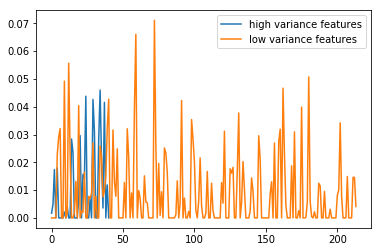

In [5]:
mi = mutual_info_classif(train_wheezy.values, target_wheezy, discrete_features=False)

feature_stds = train_wheezy.std().values

plt.plot(mi[feature_stds>1.5], label='high variance features')
plt.plot(mi[feature_stds<1.5], label='low variance features')
plt.legend()

## Fit a basic model using different feature sets

#### Using the method suggested by Chris as a baseline:
- Removing the low variance features

In [6]:
# select high variance features
train_wheezy_reduced = VarianceThreshold(1.5).fit_transform(train_wheezy)


val_scores = np.array([])
test_scores = np.array([])
SS = ShuffleSplit(n_splits=11, test_size=.15, random_state=0)
for train_index, test_index in SS.split(train_wheezy_reduced):
    clf = NuSVC(kernel='poly', degree=4, random_state=4, 
                probability=True, coef0=0.08, gamma='auto')
    clf.fit(train_wheezy_reduced[train_index,:], target_wheezy[train_index])
    
    val_preds = clf.predict_proba(train_wheezy_reduced[test_index,:])
    train_preds = clf.predict_proba(train_wheezy_reduced[train_index,:])
    
    val_score = roc_auc_score(target_wheezy[test_index], val_preds[:,1])
    train_score = roc_auc_score(target_wheezy[train_index], train_preds[:,1])
    
    val_scores = np.append(val_scores, val_score)
    train_scores = np.append(val_scores, train_score)

In [7]:
print('Validation: {0:.3f} +/- {1:.3f}'.format(np.mean(val_scores), np.std(val_scores)))
print('Train: {0:.3f} +/- {1:.3f}'.format(np.mean(train_scores), np.std(train_scores)))

Validation: 0.945 +/- 0.024
Train: 0.949 +/- 0.028


#### Using low-variance features

Now we will test using the low variance features.

In [8]:
# select low variance features
VT =  VarianceThreshold(1.5)
train_wheezy_reduced = VT.fit_transform(train_wheezy)
columns = train_wheezy.columns.values[VT.variances_<1.5]
train_wheezy_reduced = train_wheezy[columns].values


val_scores = np.array([])
test_scores = np.array([])
SS = ShuffleSplit(n_splits=11, test_size=.15, random_state=0)
for train_index, test_index in SS.split(train_wheezy_reduced):
    clf = NuSVC(kernel='poly', degree=4, random_state=4, 
                probability=True, coef0=0.08, gamma='auto')
    clf.fit(train_wheezy_reduced[train_index,:], target_wheezy[train_index])
    
    val_preds = clf.predict_proba(train_wheezy_reduced[test_index,:])
    train_preds = clf.predict_proba(train_wheezy_reduced[train_index,:])
    
    val_score = roc_auc_score(target_wheezy[test_index], val_preds[:,1])
    train_score = roc_auc_score(target_wheezy[train_index], train_preds[:,1])
    
    val_scores = np.append(val_scores, val_score)
    train_scores = np.append(val_scores, train_score)

In [9]:
print('Validation: {0:.3f} +/- {1:.3f}'.format(np.mean(val_scores),np.std(val_scores)))
print('Train: {0:.3f} +/- {1:.3f}'.format(np.mean(train_scores),np.std(train_scores)))

Validation: 0.486 +/- 0.066
Train: 0.445 +/- 0.148


#### Using mutual information

We will remove features with a low mutual information.

In [10]:
# select low variance features
mi = mutual_info_classif(train_wheezy.values, target_wheezy)
columns = train_wheezy.columns.values[mi>0.0475]
train_wheezy_reduced = train_wheezy[columns].values


val_scores = np.array([])
test_scores = np.array([])

SS = ShuffleSplit(n_splits=11, test_size=.15, random_state=0)
for train_index, test_index in SS.split(train_wheezy_reduced):
    clf = NuSVC(kernel='poly', degree=4, random_state=4, 
                probability=True, coef0=0.08, gamma='auto')
    clf.fit(train_wheezy_reduced[train_index,:], target_wheezy[train_index])
    
    val_preds = clf.predict_proba(train_wheezy_reduced[test_index,:])
    train_preds = clf.predict_proba(train_wheezy_reduced[train_index,:])
    
    val_score = roc_auc_score(target_wheezy[test_index], val_preds[:,1])
    train_score = roc_auc_score(target_wheezy[train_index], train_preds[:,1])
    
    val_scores = np.append(val_scores, val_score)
    train_scores = np.append(val_scores, train_score)

In [11]:
print('Validation: {0:.3f} +/- {1:.3f}'.format(np.mean(val_scores),np.std(val_scores)))
print('Train: {0:.3f} +/- {1:.3f}'.format(np.mean(train_scores),np.std(train_scores)))

Validation: 0.486 +/- 0.045
Train: 0.463 +/- 0.088


#### Is there any 'talk' between the low and high variance features.

Another thing to check is if there is any interaction between the low and high variance features. 

We can use a pairplot to begin to look into this. 


This quick plot doesn't indicate any strong interactions.

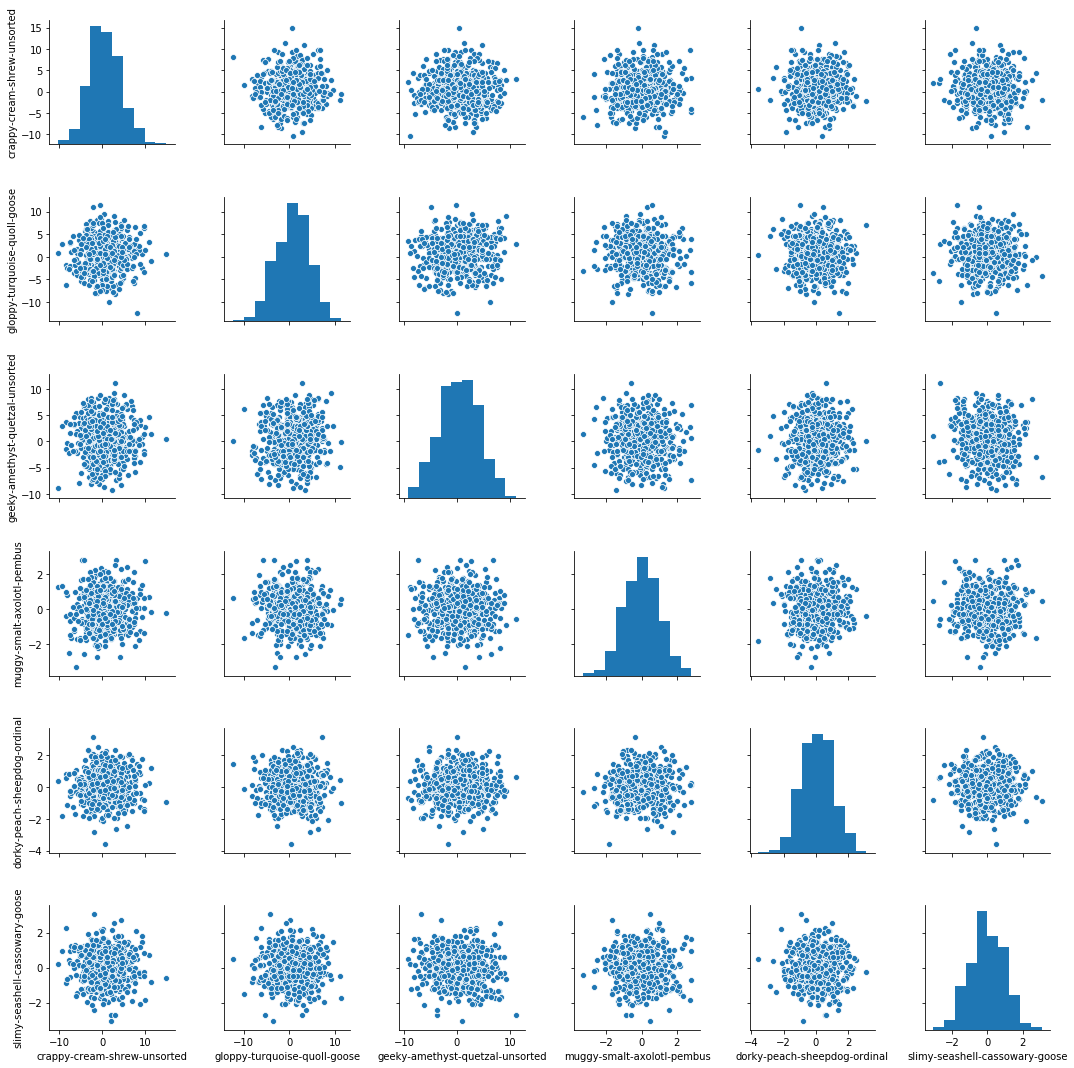

In [19]:
high_variance_features = train_wheezy.columns.values[VT.variances_>1.5][9:12]
low_variance_features = train_wheezy.columns.values[VT.variances_<1.5][:3]

features_to_plot = np.append(high_variance_features, low_variance_features)

sns.pairplot(train_wheezy[features_to_plot])

# Conclusions

Looking at the three models we have constructed it does seem to strongly support the hypothesis that the low variance features hold no predictive power. 

It seems, therefore, that a variance based thresholding is an essential first feature selection step.


Questions to answer:
 - Could they hold information in a way I am not sensitive to in this kernel? I.e., could you have features which appear random, but are not lineraly independent and when combined contain predictors of the target?